In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt

import os
from os import walk

# Question 1  - Classification with pytorch and influence of batch normalization - HW

In the previous assignment, you applied a NN to perform classification on the classic MNIST digit data set. In that task, you constructed and trained a simple NN. I will not walk through the specifics of that problem as they are in the prior assignment. Please refer back to that problem.

Now we're going to introduce batch normalization. Before each RELU, introduce batch normalization into the network (using "nn.BatchNorm1d"). So a layer such as 

nn.Linear(784, 48),

nn.ReLU(),

will be replaced by

nn.Linear(784, 48),

nn.BatchNorm1d(48),

nn.ReLU(),

Since there are multiple hidden layers with RELUs, there will be multiple batch normalization steps. Fit this model to the data both with the base model and with the model including batch normalization and plot the training and test error versus iteration. This should yield a significant improvement. It may be insightful to overlay the plots from this and Task 1 to see how the addition of batch normalization infuences training.

Task 2: Repeate the prior tasks, but with the Adam optimizer. What difference do you notice.

This exercise should illustrate that sometimes batch normalization helps and sometimes it doesn't. Be careful not to over generalize any of these results.

And again, while I will not require this, I encourage you to play with some of the hyper-parameters of this model. What happens for example if you include the batch normalization after the ReLU rather than before??

nn.Linear(784, 48),

nn.ReLU(),

nn.BatchNorm1d(48),



## Getting started with MNIST

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [4]:
batch_size = 30
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([30, 1, 28, 28])
torch.Size([1, 28, 28])
3


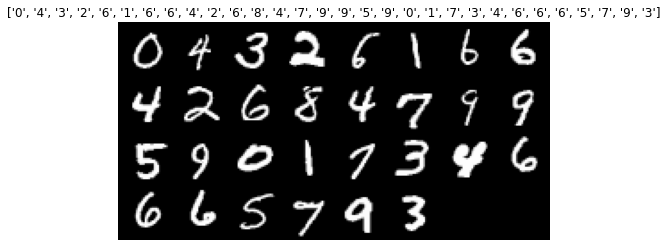

In [5]:
def imshow(img, title):
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()
    
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

images, labels = show_batch_images(trainloader)

In [7]:
# Setting up data for training
batch_size = 512 # Try varying this. Its on the large side for minibatches.
data_loader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False) # No batching or shuffling

## Setup model

In [23]:
class Base_Model(nn.Module):
    def __init__(self, width): 
        super(Base_Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784 pixels
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
#         return x
        return x

In [24]:
# The above is the basic model from the prior assignment. Suitably edit it to include batch normalization.
class BN_Model(nn.Module):
    def __init__(self, width): 
        super(BN_Model, self).__init__()
        self.classifier = nn.Sequential(
                nn.Linear(784, 48),  # 28 x 28 = 784 pixels
                nn.BatchNorm1d(48),
                nn.ReLU(),
                nn.Linear(48, 24),
                nn.BatchNorm1d(24),
                nn.ReLU(),
                nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [2]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

#####
def test(model, test_loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in test_loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector 

In [3]:


##### Train on a specific batch of data.
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

##### Iterate over epochs and all batches of data
def train(model, train_loader , test_loader , optimizer, loss_fn, epochs=5):
    losses = list()
    losses_test = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in train_loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1
            
        for x , y in test_loader:
            y_predict = model.forward(x)
            losst = loss_fn(y_predict, y)
            
            losses_test.append(losst.data.item())

#         print("Epoch: ", e+1)
#         print("Batches: ", batch_index)

    return losses , losses_test

In [4]:

def plot_loss(losses_train,loss_test, show=True):
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses_train)
    

    a = list(range(len(loss_test)))
    const = round(len(losses) / len(loss_test))
    b = [(i+1)*const for i in a]
    
    plt.plot(b,loss_test)

    if show:
        plt.show()

    plt.close()

In [27]:
# model = Base_Model()
# print(model)

In [31]:
# MNIST run (Task 1)
def run(data_loader_train, data_loader_test , model_to_test , width , weight_decay):
    
    
    # Define the hyperparameters
    learning_rate = .01
    model = model_to_test(width=width)
    
    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(model.parameters(), lr=learning_rate , weight_decay = weight_decay)
    
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss() # cross entropy loss

    # Train and get the resulting loss per iteration
    loss , loss_test = train(model=model, train_loader=data_loader_train , test_loader = data_loader_test, 
                 optimizer=optimizer, loss_fn=loss_fn)
    
    # Test and get the resulting predicted y values
    y_predict = test(model=model, test_loader=data_loader_test)

    return loss , loss_test , y_predict

Final loss base model: [1.6067827939987183]


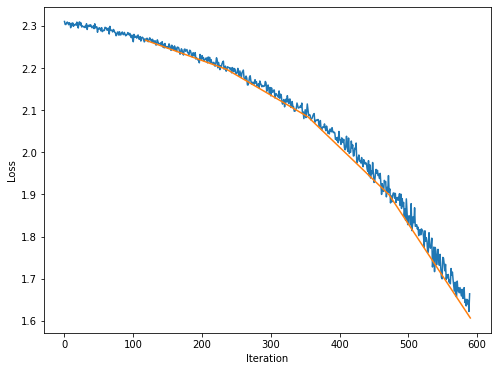

Final loss batch normalized: [0.41823363304138184]


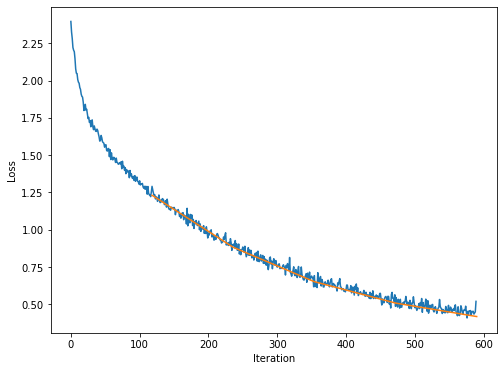

In [34]:
losses_base, loss_test_base, y_predict = run(data_loader_train=data_loader_train, data_loader_test=data_loader_test ,
                        model_to_test = Base_Model, width = 30 , weight_decay = 0)

print("Final loss base model:", loss_test_base[-1:])
plot_loss(losses_base,loss_test_base)
plt.show()

losses, loss_test, y_predict = run(data_loader_train=data_loader_train, data_loader_test=data_loader_test ,
                        model_to_test = BN_Model, width = 30 , weight_decay = 0)

print("Final loss batch normalized:", loss_test[-1:])
plot_loss(losses,loss_test)
plt.show()

In [35]:
# MNIST run (Task 2) - ADAM optimizer
def run(data_loader_train, data_loader_test , model_to_test , width , weight_decay):
    
    
    # Define the hyperparameters
    learning_rate = .01
    model = model_to_test(width=width)
    
    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate , weight_decay = weight_decay)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss() # cross entropy loss

    # Train and get the resulting loss per iteration
    loss , loss_test = train(model=model, train_loader=data_loader_train , test_loader = data_loader_test, 
                 optimizer=optimizer, loss_fn=loss_fn)
    
    # Test and get the resulting predicted y values
    y_predict = test(model=model, test_loader=data_loader_test)

    return loss , loss_test , y_predict

Task 2 - Final loss base model: [0.12274030596017838]


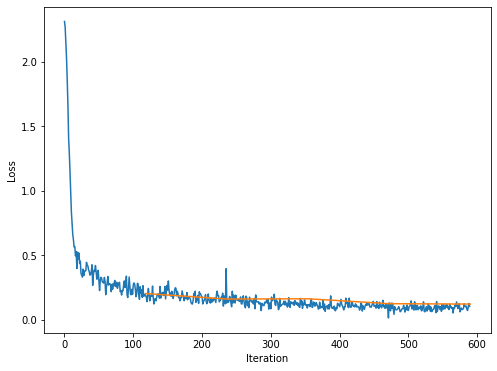

Task 2 - Final loss batch normalized: [0.09931427985429764]


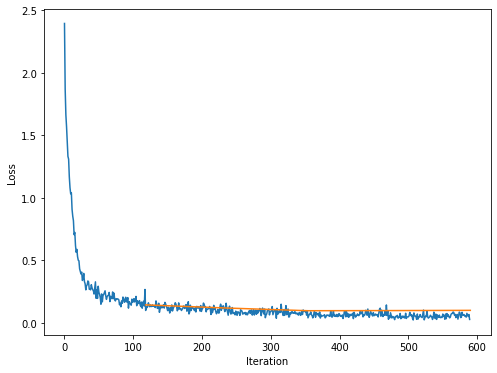

In [36]:
losses_base, loss_test_base, y_predict = run(data_loader_train=data_loader_train, data_loader_test=data_loader_test ,
                        model_to_test = Base_Model, width = 30 , weight_decay = 0)

print("Task 2 - Final loss base model:", loss_test_base[-1:])
plot_loss(losses_base,loss_test_base)
plt.show()

losses, loss_test, y_predict = run(data_loader_train=data_loader_train, data_loader_test=data_loader_test ,
                        model_to_test = BN_Model, width = 30 , weight_decay = 0)

print("Task 2 - Final loss batch normalized:", loss_test[-1:])
plot_loss(losses,loss_test)
plt.show()

## Question 2 - CNN with Blast images

Here we're going to use a pre-existing CNN to build a classifier for a medical image data set. 

NOTE: This dataset is not publically avaliable. Do not post it anywhere. Do not post this project to github or anywhere else. This data set is for internal use by VU students only.

This dataset (contained in the "experimentImages.zip" file I included), contains images of single cells from human blood. These images are used to search for the presence of blood related cancers and related pathologies (I'm not a doctor so I'll leave it at that). These are actual images taken by colleagues from the Dept. of Pathology at VUMC and are true to life images. These are not "representative" or artifical in any way. These are strait from the imaging platform.

Here we are looking to classify the distinction between two types of cells "Blast" and "Non-Blast" cells. The presence of blast cells in blood suggests a pathology is present. As such, it is important to be able to distinguish between them and normal cells (the "non-blast" cells). Here we are going to use a CNN to construct a classifier that classifies each image as either "blast" or "non-blast" (binary classification).

Rather than construct a new NN from scratch, we are going to build off of an existing network. I will note that I am going to be intentionally vague in the steps to solving this problem. I am not going to provide the code to read in or format the images for example or tell you exactly how to work with the CNN that is being used. If at any point you have trouble, let me know and I will provide guidance. I want to give you a chance to work through this from start to finish first as it is good practice.

#### The data
The data provided is pre-labeled with images of the two classes in different folders. There should be 606 images in total. Note that the dataset is not perfectly clean since some of the images are slightly different pixel numbers. You will have to deal with this. You should read these images in, resize them so that they are 300x300 pixels, break them into well mixed training and test sets, and translate them to tensors to be used in the model. Each of these steps can be preformed by packages such as torchvision with relatively few lines of code. I believe I did all of this in ~<20 lines of total code. I am intentionally leaving it to you to manage this so that you get some experience reading in and handling an imperfect data set.

#### The model
You will be using the ResNet18 model. This is an 18 layer Resnet model. You can import this directly from torchvision using ...

Model = torchvision.models.resnet18

Use exactly this model. Note that this model was originally trained on the really big imagenet database, consisting of 1000 image classes. We obviously only have 2 classes. So you will have to augment this network to accomodate the new task. I provide the code necessary to import and augment the network.

#### Task 1
In this first task, you will be fitting this model to the training data (to perform binary classification) through a process of transfer learning. There are many online resources for how to do this in pytorch. Here is one but I encourage you to use others.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

To carry this out, you will need to make two modifications to the network (which I provide code for). Note that you should import a "pretrained" version of this network for performing transfer learning.

1) First, you will want to freeze the parameters for all model layers. You can do this by setting the "requires_grad" attribute to False. Again, I'll leave it to you to learn how to do this, but we have covered what this attribute means in a past lecture video (on linear and logistic regression in pytorch). The point of transfer learning is to fix the earlier layers of the network and allow the later layers to learn based on your new data. Here, we are just fixing all parameters.

2) If you interrogate this model, you will notice that the final layer is a fully connected, linear layer with 512 inputs and 1000 outputs. The 1000 outputs correspond to the 1000 classes in the data this model was constructed for. You will need to replace this final layer with a new fully connected, input layer that has 512 inputs and 2 outputs, corresponding to the two classes. Make sure the "requires_grad" attribute on this is true, so that its gradients are calculated and its parameters can be learned.

Then fit the model to the data and quantify the test accuracy (true accuracy, not cost) as a function of training time. Note that fitting this model is the same as fitting a custom built model. You dont' need to do anything fancy for the actuall fitting.

Note that done correctly, this can all be done in <100-150 lines of code. So completing this is more a matter of figuring out how to do it, rather than cranking out lots of code. Your accuracy may very depending on specifics, but you should easily be able to attain >85% accuracy. On my 2015 iMac, this took about 45-60 mins to run on a single core. If you are ambitious, you can try to use your computers GPU for training, though it is not required (and it would not easily work on my 6 year old  computer).

#### Task 2
We're going to do the same thing as above. But instead of freezing all but the last layer of parameters, we are just going to train the entire network. Again, import a pre-trained version of this model. But this time, DO NOT freeze the layers by changing the "requires_grad" attribute. You will still need to replace the final layer with one appropriate for the data. This took my computer over 2 hours since lots more parameters are being updated.


###### Closing note
Congradulations, you just created a simple medical image classifier. Note that we just performed two ends of the spectrum. In one, we transfer learned all of the parameters of the model. In the other, we froze all but one layer and learned only the final layer. In practice, you can interpolate between these two cases (though we are not doing it here). For example, you could have different learning rates for different depth layers. High learning rates for layers near the end would promote lots of learning in those layers while progressively smaller learning rates in earlier layers cause them to learn more slowly, leading to more fine tuning than wholesale learning. You can play with this if you like, but it is not part of the assignment.

In [2]:
# Import data
from torchvision import datasets
from torch.utils.data.dataset import Dataset
from torch.utils.data import Subset
transform = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder('./experimentImages/', transform=transform)
# dataset = datasets.ImageFolder('D:\Mayna\Documents\PHYS8100\experimentImages\experimentImages', transform=transform)

# Split into train/test set
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(trainset))
print(len(testset))

424
182


In [3]:
# Setting up data for training
batch_size = 32 
data_loader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True) # No batching or shuffling
data_loader_train_all = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)

images, labels = next(iter(data_loader_test))

### Import and setup model.

Step 1: Import pretrained ResNet18

Step 2: Freeze the parameters of all layers by setting requires_grad = False

Step 3: Replace the final FC layer with our own.

Note that the purpose of step 3 is as follows. In the original imagenet problem, this final layer would have output the probabilities of 20,000 classes. Our problem however only involves 2 classes. So we need our own FC classification layer. When we replace this layer, we have to ensure that it takes the proper input size. If you print the Model, you will notice that the very last CNN block (bn2) outputs a feature vector of size 512. We need to make sure that our new FC layer takes the appropriate size feature input (512), and produces the proper size output (2 classes). Note that the parameters of this new FC layer will be initialized randomly and requires_grad = True will be the default. 

The resulting network will have a bunch of pretrained, frozen layers, with a fresh FC layer on the end that will be trained for our specific problem.

In [16]:
Model = torchvision.models.resnet18(pretrained=True)

for param in Model.parameters():
    param.requires_grad = False
    
Model.fc = nn.Linear(512,2)

In [17]:
lr_rate = 1e-4
epochs = 50
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr = lr_rate)

In [21]:
# run model
iter = 0
acc_keep = np.array([])
train_loss,train_acc =[],[]
for e in range(epochs):

    for i, (images, labels) in enumerate(data_loader_train):
        optimizer.zero_grad()
        outputs = Model(images)
        loss = loss_fun(outputs,labels)
        loss.backward()
        optimizer.step()
        
        iter +=1
        if iter%100 == 0:
            correct = 0
            total = 0
            for images, labels in data_loader_test:
                outputs = Model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
            # calculate accuracy on train     
            correct_train = 0
            total_train = 0
            for images, labels in data_loader_train_all:
                outputs = Model(images)
                _, predicted = torch.max(outputs.data,1)
                total_train+= labels.size(0)
                correct_train+= (predicted == labels).sum()
                
            accuracy = 100*correct.numpy()/total
            accuracy_train = 100*correct_train.numpy()/total_train
            acc_keep = np.append(acc_keep,accuracy)
            print("Iteration: {}. Loss: {}. Accuracy Train: {}. Accuracy Test: {}. ".format(iter, loss.item(), accuracy_train, accuracy))

Iteration: 100. Loss: 0.3915012776851654. Accuracy Train: 88.67924528301887. Accuracy Test: 86.26373626373626. 
Iteration: 200. Loss: 0.33808186650276184. Accuracy Train: 88.91509433962264. Accuracy Test: 87.91208791208791. 
Iteration: 300. Loss: 0.3613271117210388. Accuracy Train: 90.09433962264151. Accuracy Test: 87.91208791208791. 
Iteration: 400. Loss: 0.3512553870677948. Accuracy Train: 90.56603773584905. Accuracy Test: 87.91208791208791. 
Iteration: 500. Loss: 0.35719385743141174. Accuracy Train: 91.0377358490566. Accuracy Test: 88.46153846153847. 
Iteration: 600. Loss: 0.3114794194698334. Accuracy Train: 91.0377358490566. Accuracy Test: 88.46153846153847. 
Iteration: 700. Loss: 0.44433489441871643. Accuracy Train: 91.50943396226415. Accuracy Test: 90.10989010989012. 


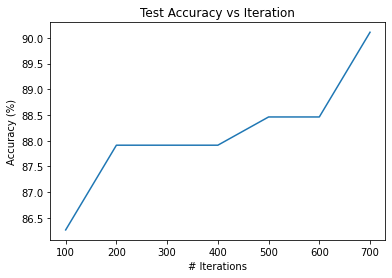

In [26]:
fig = plt.figure()
iter_array = np.arange(100,800,100)
plt.plot(iter_array, acc_keep)
plt.title('Test Accuracy vs Iteration')
plt.xlabel('# Iterations')
plt.ylabel('Accuracy (%)')
plt.show()

In [4]:
# Task 2

Model = torchvision.models.resnet18(pretrained=True)
    
Model.fc = nn.Linear(512,2)

In [5]:
lr_rate = 1e-4
epochs = 50
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr = lr_rate)

In [6]:
# run model
iter = 0
acc_keep = np.array([])
train_loss,train_acc =[],[]
for e in range(epochs):

    for i, (images, labels) in enumerate(data_loader_train):
        optimizer.zero_grad()
        outputs = Model(images)
        loss = loss_fun(outputs,labels)
        loss.backward()
        optimizer.step()
        
        iter +=1
        if iter%100 == 0:
            correct = 0
            total = 0
            for images, labels in data_loader_test:
                outputs = Model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
            # calculate accuracy on train     
            correct_train = 0
            total_train = 0
            for images, labels in data_loader_train_all:
                outputs = Model(images)
                _, predicted = torch.max(outputs.data,1)
                total_train+= labels.size(0)
                correct_train+= (predicted == labels).sum()
                
            accuracy = 100*correct.numpy()/total
            accuracy_train = 100*correct_train.numpy()/total_train
            acc_keep = np.append(acc_keep,accuracy)
            print("Iteration: {}. Loss: {}. Accuracy Train: {}. Accuracy Test: {}. ".format(iter, loss.item(), accuracy_train, accuracy))

Iteration: 100. Loss: 0.001222944469191134. Accuracy Train: 100.0. Accuracy Test: 96.7032967032967. 
Iteration: 200. Loss: 0.0013930040877312422. Accuracy Train: 100.0. Accuracy Test: 98.9010989010989. 
Iteration: 300. Loss: 0.013833347707986832. Accuracy Train: 98.58490566037736. Accuracy Test: 94.50549450549451. 
Iteration: 400. Loss: 0.0008496601949445903. Accuracy Train: 100.0. Accuracy Test: 98.35164835164835. 
Iteration: 500. Loss: 0.0010737909469753504. Accuracy Train: 100.0. Accuracy Test: 98.9010989010989. 
Iteration: 600. Loss: 0.00020400239736773074. Accuracy Train: 100.0. Accuracy Test: 99.45054945054945. 
Iteration: 700. Loss: 0.0027772674802690744. Accuracy Train: 100.0. Accuracy Test: 99.45054945054945. 


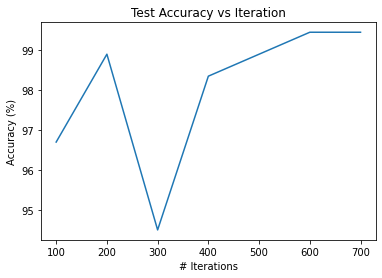

In [8]:
fig = plt.figure()
iter_array = np.arange(100,800,100)
plt.plot(iter_array, acc_keep)
plt.title('Test Accuracy vs Iteration')
plt.xlabel('# Iterations')
plt.ylabel('Accuracy (%)')
plt.show()

#### discussion
Not sure why the accuracy started so high, I would guess that the network somehow remembered the training from the past run, even though I cleared the kernel and ran a new model. 